# Modeling

In [17]:
from collections import defaultdict
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from copy import deepcopy
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder

In [4]:
# integrating our preprocessing into a pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

In [5]:
# importing our corpues i.e., our processed tokens
corpus = pd.read_csv('data/spotify-reviews.csv')
corpus = corpus.rename(columns={'review':'tokens'})
spotify_df = pd.read_csv('data/preprocessed-reviews.csv')
spotify_reviews = pd.concat([spotify_df,corpus],axis=1)

In [7]:
data = spotify_reviews[spotify_reviews.sentiment.isin(['pos','neg'])]
data

,review,rating,total_thumbs_up,replied,comp_score,pos_score,neg_score,sentiment,tokens
0,"great music service, the audio is high quality...",5,2,0,0.9211,0.436,0.000,pos,great music service audio high quality app eas...
1,please ignore previous negative rating. this a...,5,1,0,0.6249,0.404,0.243,pos,please ignore previous negative rating app sup...
2,"this pop-up ""get the best spotify experience o...",4,0,0,0.5859,0.258,0.107,pos,get best spotify experience android annoy plea...
3,really buggy and terrible to use as of recently,1,1,0,-0.5209,0.000,0.296,neg,really buggy terrible use recently
4,dear spotify why do i get songs that i didn't ...,1,1,0,0.7149,0.260,0.000,pos,dear spotify get song put playlist shuffle play
...,...,...,...,...,...,...,...,...,...
61589,even though it was communicated that lyrics fe...,1,6,0,-0.2960,0.047,0.072,neg,even communicate lyric feature available user ...
61590,"use to be sooo good back when i had it, and wh...",1,0,0,0.8481,0.227,0.069,pos,use sooo good back download free version pick ...
61591,this app would be good if not for it taking ov...,2,10,0,-0.9611,0.046,0.225,neg,app good take device start comp spotify start ...
61592,the app is good hard to navigate and won't jus...,2,1,0,0.8074,0.159,0.023,pos,app good hard navigate let play song click pla...


In [9]:
# instantiating our label encoder so that we can label our classes
label_enc = LabelEncoder()

In [10]:
X = data.tokens
y = data.sentiment
y = label_enc.fit_transform(y)

In [11]:
# looking at our class distribution 
data.sentiment.value_counts(normalize=True)

pos    0.695899
neg    0.304101
Name: sentiment, dtype: float64

In [12]:
# for more detailed labels later on 
class_labels = ['Negative','Positive']

In [13]:
# splitting our data into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [43]:
# creating a pipeline for our vectorizer 
pre_process_steps = [('tfdif', TfidfVectorizer(min_df=.05,max_df=.95))]
preprocess_pipeline = Pipeline(pre_process_steps)
preprocess_pipeline

Pipeline(steps=[('tfdif', TfidfVectorizer(max_df=0.95, min_df=0.05))])

## Creating a Baseline DummyClassifier Model

In [44]:
# transforming our training and test data 
#X_train_processed = preprocess_pipeline.fit_transform(X_train)
#X_test_processed = preprocess_pipeline.transform(X_test)

To evaluate our future models, we'll use `DummyClasifier` from sklearn ~ 

In [45]:
from sklearn.dummy import DummyClassifier

In [46]:
dummy_pipe = deepcopy(preprocess_pipeline)
dummy_pipe.steps.append(('dummy_clf',DummyClassifier(random_state=418)))
dummy_pipe

Pipeline(steps=[('tfdif', TfidfVectorizer(max_df=0.95, min_df=0.05)),
                ('dummy_clf', DummyClassifier(random_state=418))])

In [47]:
# fitting our pipeline on the training data 
dummy_pipe.fit(X_train,y_train)

Pipeline(steps=[('tfdif', TfidfVectorizer(max_df=0.95, min_df=0.05)),
                ('dummy_clf', DummyClassifier(random_state=418))])

In [48]:
#extracting our predictions 
preds = dummy_pipe.predict(X_test)

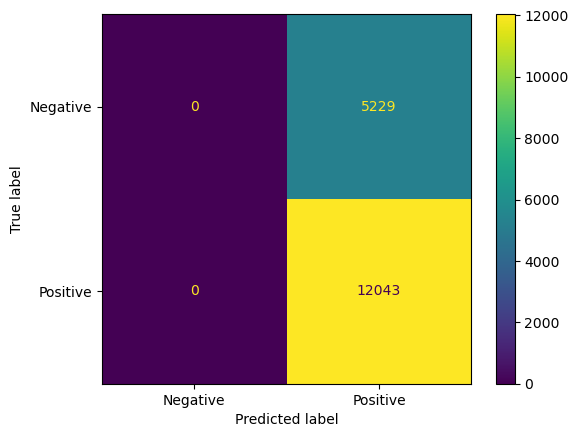

In [49]:
# creating a confusion matrix for our baseline model 
ConfusionMatrixDisplay.from_predictions(y_test,preds,display_labels=['Negative','Positive'])

In [51]:
dummy_pipe.score(X_test,y_test)

0.6972556739231126

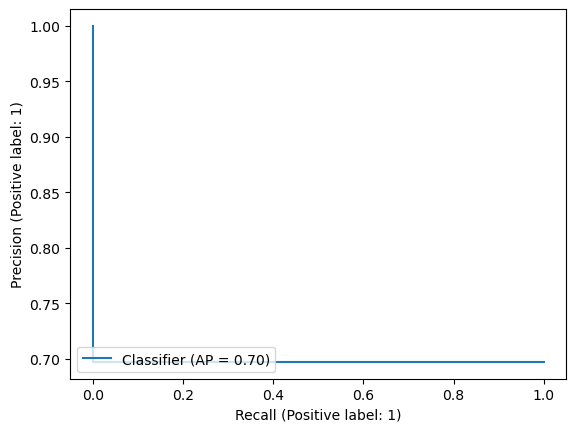

In [52]:
# plotting the precision-recall curve 
PrecisionRecallDisplay.from_predictions(y_test, preds)

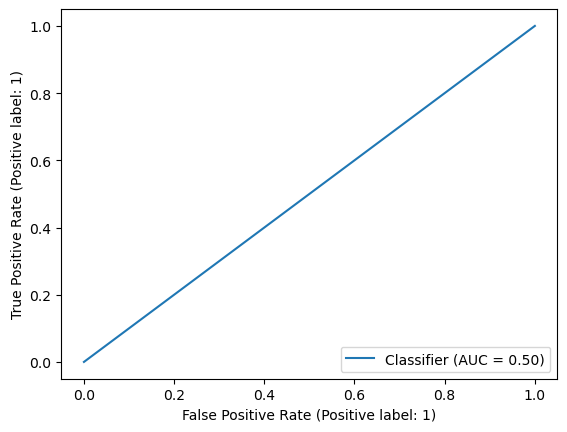

In [53]:
RocCurveDisplay.from_predictions(y_test, preds)

In [54]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5229
           1       0.70      1.00      0.82     12043

    accuracy                           0.70     17272
   macro avg       0.35      0.50      0.41     17272
weighted avg       0.49      0.70      0.57     17272



C:\Users\Kevin\anaconda3\envs\spotify-proj\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Kevin\anaconda3\envs\spotify-proj\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Kevin\anaconda3\envs\spotify-proj\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### RandomForestClassifier

In [55]:
from sklearn.ensemble import RandomForestClassifier

In [56]:
rf_pipe = deepcopy(preprocess_pipeline)
rf_pipe.steps.append(('rf_clf',RandomForestClassifier(random_state=42)))
rf_pipe

Pipeline(steps=[('tfdif', TfidfVectorizer(max_df=0.95, min_df=0.05)),
                ('rf_clf', RandomForestClassifier(random_state=42))])

In [57]:
rf_pipe.fit(X_train,y_train)

Pipeline(steps=[('tfdif', TfidfVectorizer(max_df=0.95, min_df=0.05)),
                ('rf_clf', RandomForestClassifier(random_state=42))])

In [30]:
#X_test_processed = preprocess_pipeline.transform(X_test)

In [59]:
preds2 = rf_pipe.predict(X_test)

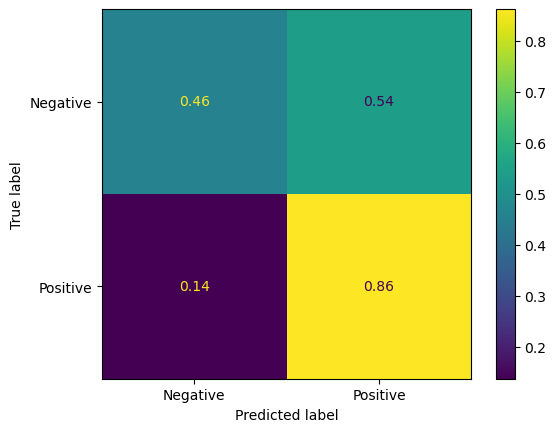

In [60]:
ConfusionMatrixDisplay.from_predictions(y_test, preds2,normalize='true',display_labels=class_labels)

In [63]:
rf_pipe.score(X_test,y_test)

0.7406206577119037

In [64]:
print(classification_report(y_test,preds2))

              precision    recall  f1-score   support

           0       0.59      0.46      0.52      5229
           1       0.79      0.86      0.82     12043

    accuracy                           0.74     17272
   macro avg       0.69      0.66      0.67     17272
weighted avg       0.73      0.74      0.73     17272



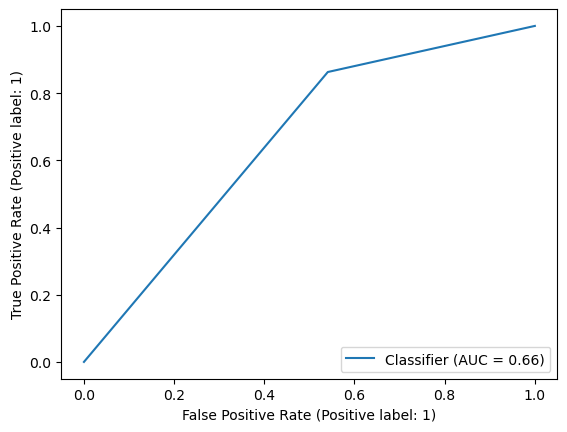

In [66]:
RocCurveDisplay.from_predictions(y_test,preds2)

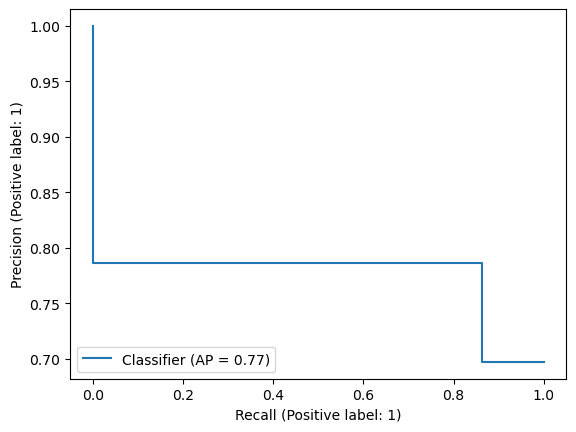

In [67]:
PrecisionRecallDisplay.from_predictions(y_test,preds2)

## Model Tuning

### Logistic Regression

In [68]:
from sklearn.linear_model import LogisticRegression

In [72]:
log_pipe = deepcopy(preprocess_pipeline)
log_pipe.steps.append(('log_reg',LogisticRegression(random_state=418)))
log_pipe

Pipeline(steps=[('tfdif', TfidfVectorizer(max_df=0.95, min_df=0.05)),
                ('log_reg', LogisticRegression(random_state=418))])

In [73]:
log_pipe.fit(X_train,y_train)

Pipeline(steps=[('tfdif', TfidfVectorizer(max_df=0.95, min_df=0.05)),
                ('log_reg', LogisticRegression(random_state=418))])

In [75]:
preds3 = log_pipe.predict(X_test)

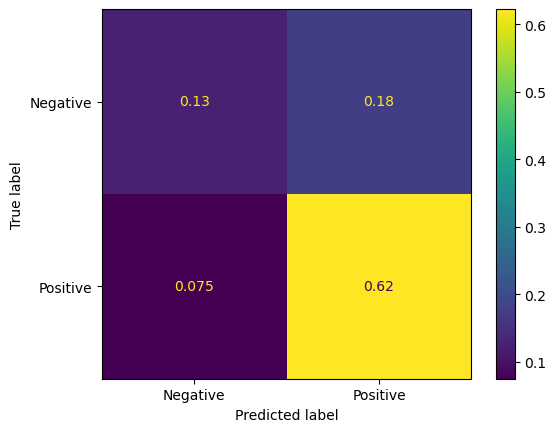

In [76]:
ConfusionMatrixDisplay.from_predictions(y_test, preds3,normalize='all',display_labels=class_labels)

In [77]:
print(classification_report(y_test,preds3))

              precision    recall  f1-score   support

           0       0.63      0.42      0.50      5229
           1       0.78      0.89      0.83     12043

    accuracy                           0.75     17272
   macro avg       0.70      0.65      0.67     17272
weighted avg       0.73      0.75      0.73     17272



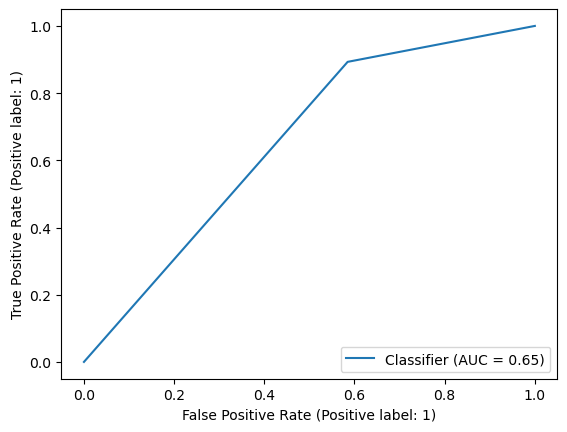

In [78]:
RocCurveDisplay.from_predictions(y_test,preds3)

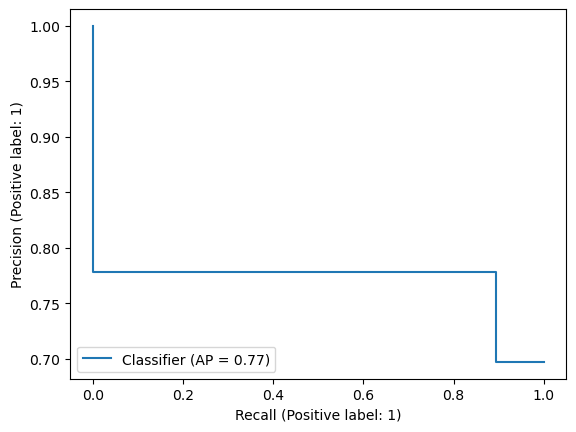

In [79]:
PrecisionRecallDisplay.from_predictions(y_test,preds3)

## Hyperparamter Tuning

In [127]:
log_pipe.steps

[('tfdif', TfidfVectorizer(max_df=0.95, min_df=0.05)),
 ('log_reg', LogisticRegression(random_state=418))]

In [131]:
random_cv_params = {'tfdif__min_df':[.01,.03,.05],
                    'tfdif__max_df':[.85,.90,.95],
                    'log_reg__C':[1e-3,1e-2,1e-1,1,1.01],
                    'log_reg__max_iter':[100,120,140]}

In [132]:
random_cv = RandomizedSearchCV(estimator=log_pipe,
                               param_distributions=random_cv_params,
                               cv=5)
random_cv.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfdif',
                                              TfidfVectorizer(max_df=0.95,
                                                              min_df=0.05)),
                                             ('log_reg',
                                              LogisticRegression(random_state=418))]),
                   param_distributions={'log_reg__C': [0.001, 0.01, 0.1, 1,
                                                       1.01],
                                        'log_reg__max_iter': [100, 120, 140],
                                        'tfdif__max_df': [0.85, 0.9, 0.95],
                                        'tfdif__min_df': [0.01, 0.03, 0.05]})

In [133]:
random_cv.best_params_, random_cv.best_score_

({'tfdif__min_df': 0.01,
  'tfdif__max_df': 0.85,
  'log_reg__max_iter': 120,
  'log_reg__C': 1.01},
 0.8121387786613425)

In [134]:
best_log_preds = random_cv.best_estimator_.predict(X_test)

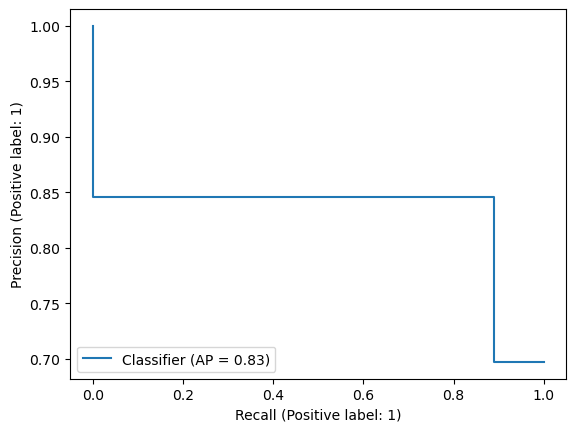

In [135]:
PrecisionRecallDisplay.from_predictions(y_test,best_log_preds)

In [138]:
pd.DataFrame(random_cv.cv_results_).sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tfdif__min_df,param_tfdif__max_df,param_log_reg__max_iter,param_log_reg__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,0.500374,0.020149,0.097792,0.001767,0.01,0.85,120,1.01,"{'tfdif__min_df': 0.01, 'tfdif__max_df': 0.85,...",0.807220,0.807196,0.811042,0.817246,0.817990,0.812139,0.004694,1
6,0.466553,0.003700,0.097737,0.002377,0.01,0.95,120,0.1,"{'tfdif__min_df': 0.01, 'tfdif__max_df': 0.95,...",0.798164,0.798015,0.799256,0.808933,0.810918,0.803057,0.005659,2
7,0.475005,0.012499,0.095637,0.001209,0.01,0.9,120,0.1,"{'tfdif__min_df': 0.01, 'tfdif__max_df': 0.9, ...",0.798164,0.798015,0.799256,0.808933,0.810918,0.803057,0.005659,2
1,0.456770,0.018305,0.101185,0.001624,0.03,0.95,140,1,"{'tfdif__min_df': 0.03, 'tfdif__max_df': 0.95,...",0.769259,0.769727,0.771216,0.778040,0.778660,0.773380,0.004113,4
4,0.448199,0.004408,0.101558,0.000995,0.03,0.95,100,1.01,"{'tfdif__min_df': 0.03, 'tfdif__max_df': 0.95,...",0.769508,0.769603,0.771216,0.777792,0.778660,0.773356,0.004032,5


### Naive Bayes

In [80]:
from sklearn.naive_bayes import MultinomialNB

In [81]:
multiNB_pipe = deepcopy(preprocess_pipeline)
multiNB_pipe.steps.append(('multiNB',MultinomialNB()))
multiNB_pipe

Pipeline(steps=[('tfdif', TfidfVectorizer(max_df=0.95, min_df=0.05)),
                ('multiNB', MultinomialNB())])

In [82]:
multiNB_pipe.fit(X_train,y_train)

Pipeline(steps=[('tfdif', TfidfVectorizer(max_df=0.95, min_df=0.05)),
                ('multiNB', MultinomialNB())])

In [84]:
preds4 = multiNB_pipe.predict(X_test)

In [85]:
print(classification_report(y_test, preds4))

              precision    recall  f1-score   support

           0       0.66      0.18      0.28      5229
           1       0.73      0.96      0.83     12043

    accuracy                           0.72     17272
   macro avg       0.70      0.57      0.56     17272
weighted avg       0.71      0.72      0.66     17272



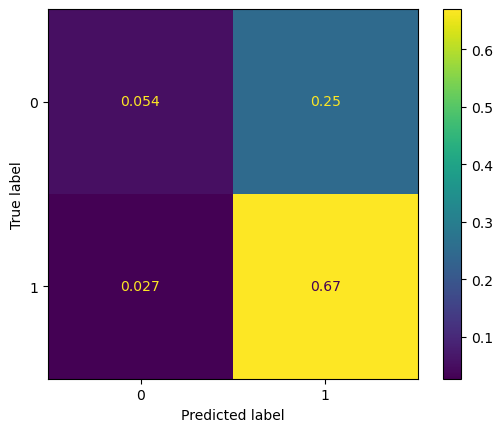

In [86]:
ConfusionMatrixDisplay.from_predictions(y_test, preds4,normalize='all')

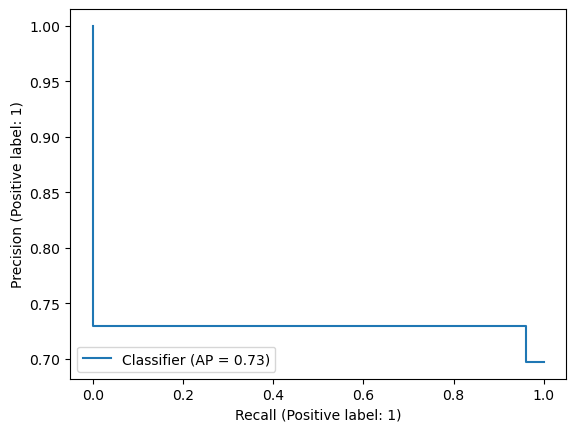

In [87]:
PrecisionRecallDisplay.from_predictions(y_test,preds4)

### Complement Naive Bayes

In [88]:
from sklearn.naive_bayes import ComplementNB

In [89]:
compNB_pipe = deepcopy(preprocess_pipeline)
compNB_pipe.steps.append(('compNB',ComplementNB()))
compNB_pipe

Pipeline(steps=[('tfdif', TfidfVectorizer(max_df=0.95, min_df=0.05)),
                ('compNB', ComplementNB())])

In [90]:
compNB_pipe.fit(X_train,y_train)

Pipeline(steps=[('tfdif', TfidfVectorizer(max_df=0.95, min_df=0.05)),
                ('compNB', ComplementNB())])

In [92]:
preds5 = compNB_pipe.predict(X_test)

In [93]:
print(classification_report(y_test, preds5))

              precision    recall  f1-score   support

           0       0.48      0.79      0.60      5229
           1       0.88      0.63      0.73     12043

    accuracy                           0.68     17272
   macro avg       0.68      0.71      0.67     17272
weighted avg       0.76      0.68      0.69     17272



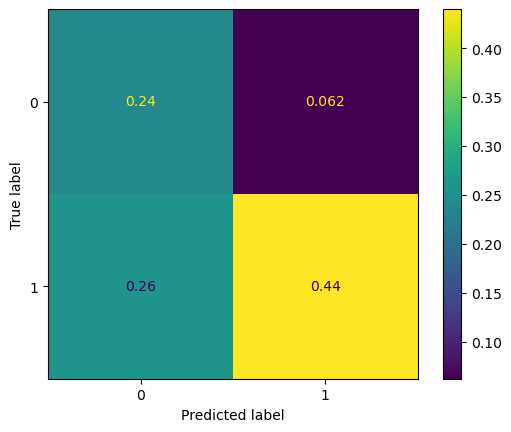

In [94]:
ConfusionMatrixDisplay.from_predictions(y_test, preds5,normalize='all')

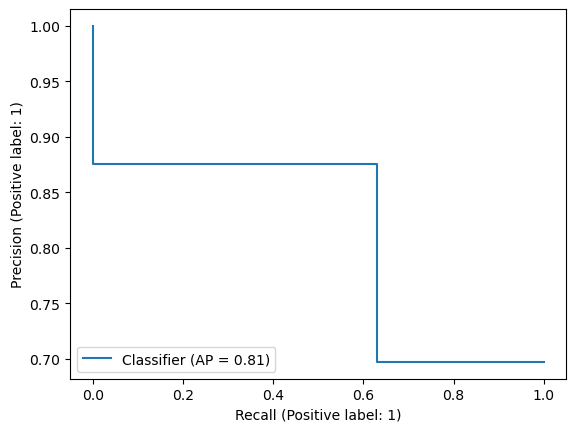

In [95]:
PrecisionRecallDisplay.from_predictions(y_test,preds5)

### XGBoost Model 

In [96]:
from xgboost import XGBClassifier

In [97]:
xgb_pipe = deepcopy(preprocess_pipeline)
xgb_pipe.steps.append(('xgbModel',XGBClassifier(random_state=42)))
xgb_pipe

Pipeline(steps=[('tfdif', TfidfVectorizer(max_df=0.95, min_df=0.05)),
                ('xgbModel',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

In [99]:
xgb_pipe.fit(X_train,y_train)
preds6 = xgb_pipe.predict(X_test)

In [100]:
print(classification_report(y_test, preds6))

              precision    recall  f1-score   support

           0       0.61      0.45      0.52      5229
           1       0.79      0.87      0.83     12043

    accuracy                           0.75     17272
   macro avg       0.70      0.66      0.67     17272
weighted avg       0.73      0.75      0.74     17272



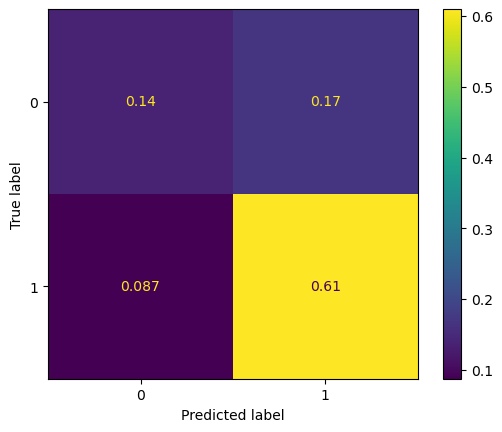

In [101]:
ConfusionMatrixDisplay.from_predictions(y_test, preds6,normalize='all')

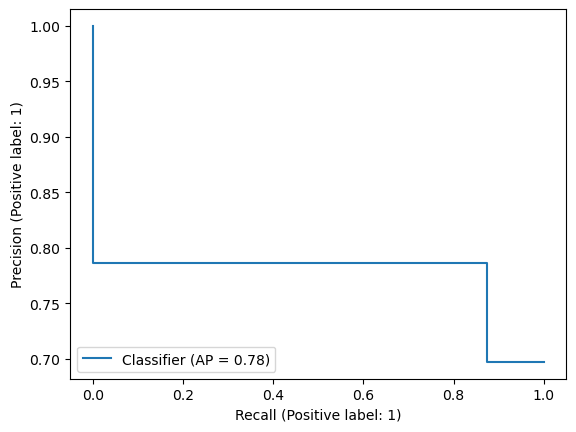

In [102]:
PrecisionRecallDisplay.from_predictions(y_test,preds6)